In [1]:
import json
import pickle
import numpy as np
import matplotlib as mpl
from geopy import distance
from cmcrameri import cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

with open("../config.json", "r") as f:
    config = json.load(f)

with open("output/assembled.pkl", "rb") as handle:
    assembled = pickle.load(handle)

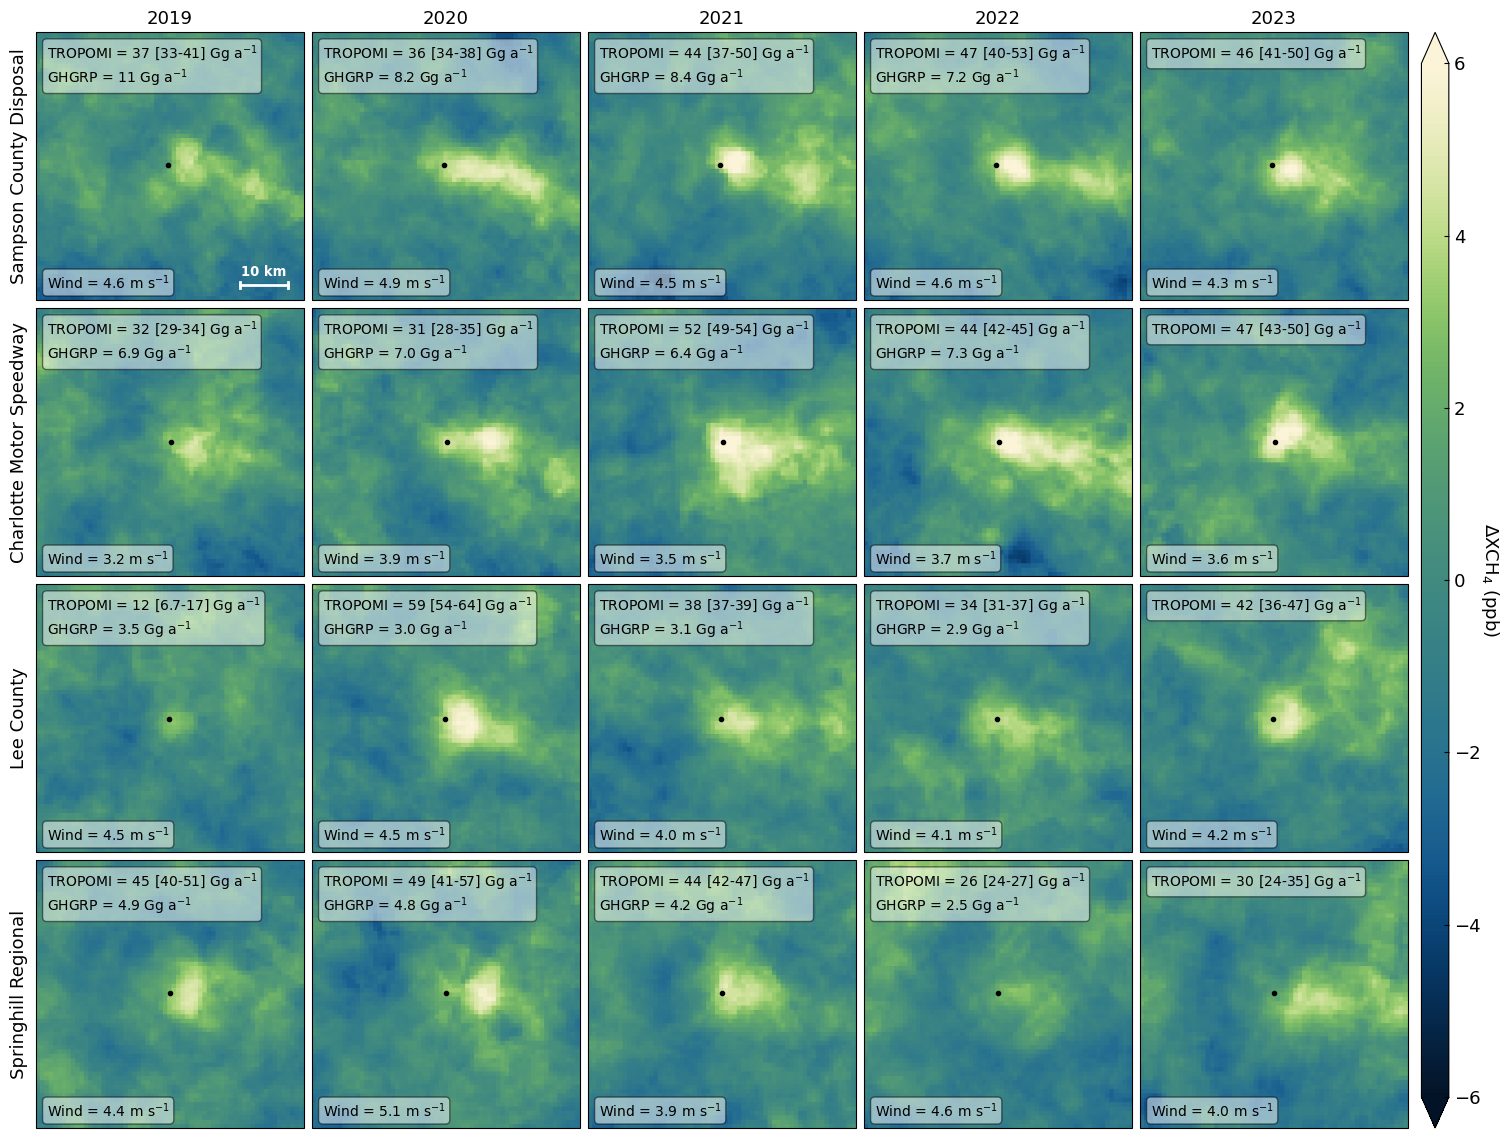

In [2]:
# Setup figure 1
fig,axs = plt.subplots(4,5,figsize=(15,12), layout="compressed",
                       subplot_kw={"projection": ccrs.PlateCarree()})

for idx,landfill in enumerate(["sampson", "charlotte", "lee", "springhill"]):
    
    source_lon = config["landfills"][landfill]["lon"]
    source_lat = config["landfills"][landfill]["lat"]
    extent = [float(f"{round(source_lon, 2) - 0.3:.2f}")-0.005,
              float(f"{round(source_lon, 2) + 0.3:.2f}")+0.005,
              float(f"{round(source_lat, 2) - 0.3:.2f}")-0.005,
              float(f"{round(source_lat, 2) + 0.3:.2f}")+0.005,]
    
    for idy,year in enumerate(range(2019,2024)):

        # Plot the oversampled data
        gdf = assembled[landfill][f"oversampled-{year}"]
        gdf.plot(ax=axs[idx,idy], column="delta_xch4_ppb", legend=False,
                 cmap=cm.navia, vmin=-6, vmax=6)
        axs[idx,idy].set_extent(extent, crs=ccrs.PlateCarree())
        axs[idx,idy].scatter(source_lon, source_lat, marker=".", color="k")

        # Add text boxes
        df = assembled[landfill]["data"]
        satellite = df["Emis_Satellite"].iloc[idy] # [Gg/yr]
        satellite_lower = df["Emis_Satellite_Lower"].iloc[idy] # [Gg/yr]
        satellite_upper = df["Emis_Satellite_Upper"].iloc[idy] # [Gg/yr]
        epa_ghgrp = df["Emis_Reported"].iloc[idy]/25/1e3 # [Gg/yr]
        wind = df["Wind_Satellite"].iloc[idy]/60/60 # [m/s]
        textstr = f"TROPOMI = {satellite:.2g}"
        textstr += f" [{satellite_lower:.2g}-{satellite_upper:.2g}] "
        textstr += r"Gg a$^{-1}$"
        if idy != 4:
            assert int(df["year"].iloc[idy]) == year
            if epa_ghgrp < 10:
                textstr += f"\nGHGRP = {epa_ghgrp:.1f} " + r"Gg a$^{-1}$"
            else:
                textstr += f"\nGHGRP = {epa_ghgrp:.2g} " + r"Gg a$^{-1}$"
        axs[idx,idy].text(0.04, 0.96, textstr, transform=axs[idx,idy].transAxes,
                          fontsize=10, verticalalignment="top", bbox=dict(
                          boxstyle="round", facecolor="white", alpha=0.5))
        textstr = f"Wind = {wind:.1f} " + r"m s$^{-1}$"
        axs[idx,idy].text(0.04, 0.1, textstr, transform=axs[idx,idy].transAxes,
                fontsize=10, verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

        # Determine how long 10 km is on this scale and plot it
        if idx == 0 and idy == 0:
            df = assembled[landfill][f"oversampled-{year}"]
            for i in df.index:
                thr = 0.001
                c1 = abs(round(source_lat,2)-0.27-df.loc[i,"lat_center"]) < thr
                c2 = abs(round(source_lon,2)+0.16-df.loc[i,"lon_center"]) < thr
                if c1 & c2:
                    start_scale_lon = df.loc[i,"lon_center"]
                    end_scale_lon = df.loc[i,"lon_center"] + 0.001
                    scale_lat = df.loc[i,"lat_center"]
            diff = 1
            while diff >= 0.001:
                dist = distance.distance(
                    (scale_lat,start_scale_lon),
                    (scale_lat,end_scale_lon)).km
                diff = abs(dist-10)
                end_scale_lon += 0.00001
            axs[idx,idy].plot([start_scale_lon,end_scale_lon],
                              [scale_lat,scale_lat], color="w", linewidth=2)
            axs[idx,idy].plot([start_scale_lon,start_scale_lon],
                              [scale_lat-0.007,scale_lat+0.007],
                              color="w", linewidth=2)
            axs[idx,idy].plot([end_scale_lon,end_scale_lon],
                              [scale_lat-0.007,scale_lat+0.007],
                              color="w", linewidth=2)
            axs[idx,idy].text((start_scale_lon+end_scale_lon)/2, scale_lat+0.02, 
                              "10 km", horizontalalignment="center",
                              fontsize=9.5, color="w", fontweight="bold")
        
        # Set axis labels and titles
        if idx == 0:
            axs[idx,idy].set_title(year, fontsize=13)
        if idy == 0:
            labels = {"sampson": "Sampson County Disposal",
                      "charlotte": "Charlotte Motor Speedway",
                      "lee": "Lee County",
                      "springhill" : "Springhill Regional"}
            axs[idx,idy].text(-0.03, 0.5, labels[landfill], va='bottom',
                              ha='center', rotation='vertical',
                              rotation_mode='anchor',
                              transform=axs[idx,idy].transAxes, fontsize=13)

# Add colorbar and save the figure
cb = fig.colorbar(mpl.cm.ScalarMappable(
       norm=mpl.colors.Normalize(vmin=-6, vmax=6), cmap=cm.navia),
       ax=axs, pad=0.01, aspect=40, extend="both", extendfrac=0.03)
cb.set_label("$\Delta$XCH$_4$ (ppb)", fontsize=13, rotation=270, labelpad=15)
cb.ax.yaxis.set_tick_params(labelsize=13, labelcolor="black", direction="in")
fig.savefig(f"figures/fig1.png", dpi=300, bbox_inches="tight", pad_inches=0)

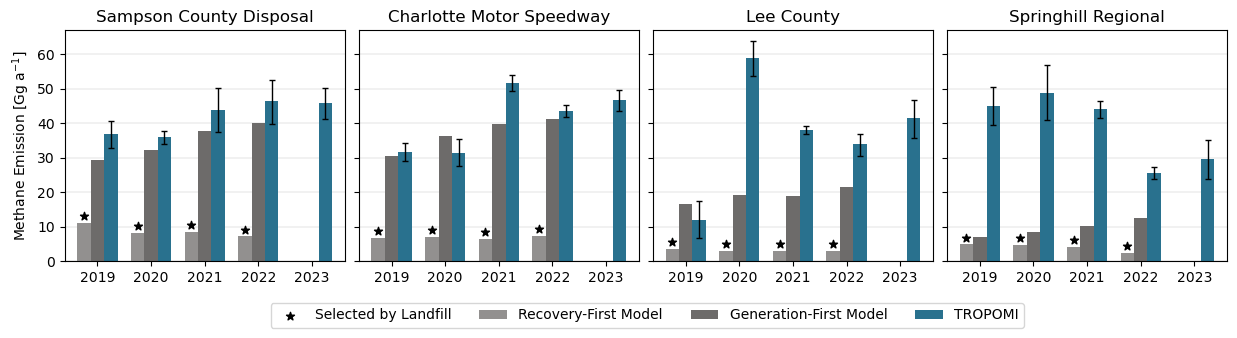

In [3]:
# Setup figure 2
fig,axs = plt.subplots(1,4, figsize=(15,3), sharey=True)
x = np.arange(2019,2024)
width = 0.25
for idx,landfill in enumerate(["sampson", "charlotte", "lee", "springhill"]):
    df = assembled[landfill]["data"]
    axs[idx].bar(x-width, df["Emis_Recovery_First"]/25/1e3, width,
                 color="#92908f", label="Recovery-First Model")
    axs[idx].bar(x, df["Emis_Generation_First"]/25/1e3, width,
                 color="#6d6b6a", label="Generation-First Model")
    l_err = (df["Emis_Satellite"]-df["Emis_Satellite_Lower"])
    u_err = (df["Emis_Satellite"]-df["Emis_Satellite_Upper"]).abs()
    axs[idx].bar(x+width, df["Emis_Satellite"], width, yerr=(l_err,u_err),
                 capsize=2, color="#29718e", label="TROPOMI",
                 error_kw={"elinewidth": 1})
    axs[idx].set_title(labels[landfill])
    axs[idx].grid(axis="y", linewidth=0.25)
    axs[idx].set_axisbelow(True)
    assert (df["Type"].iloc[0:4] == "Chose_Recovery_First").all()
    axs[idx].scatter(x-width, df["Emis_Recovery_First"]/25/1e3 + 2,
                     marker="*", color="k", label="Selected by Landfill")

axs[0].legend(ncol=4, bbox_to_anchor=(3.45, -0.15))
axs[0].set_ylabel(r"Methane Emission [Gg a$^{-1}$]")
fig.subplots_adjust(wspace=0.05)
fig.savefig("figures/fig2.png", dpi=300, bbox_inches="tight", pad_inches=0.01)

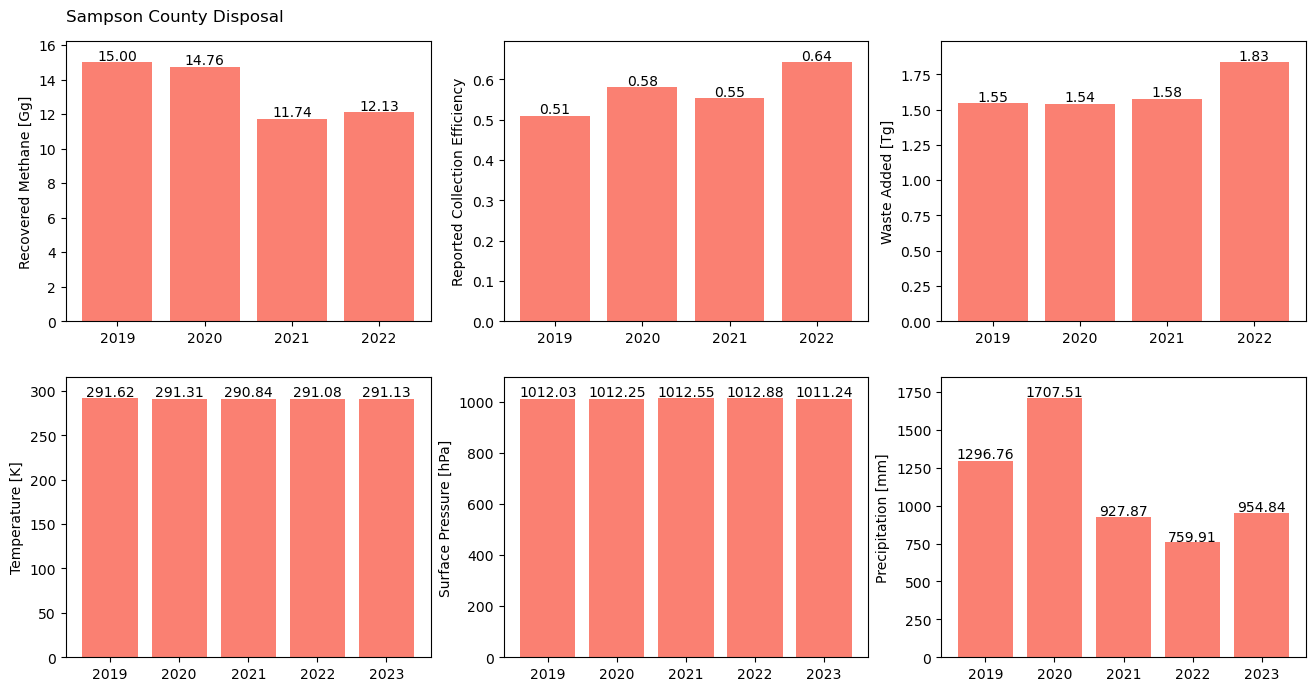

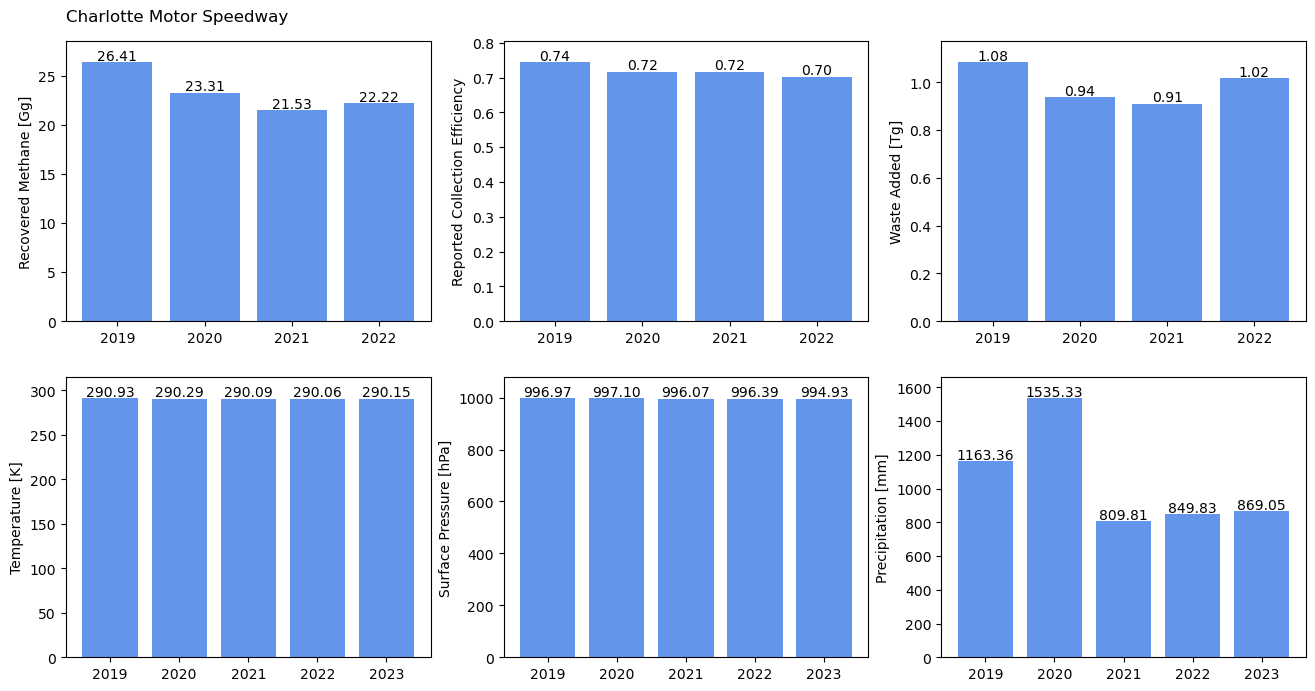

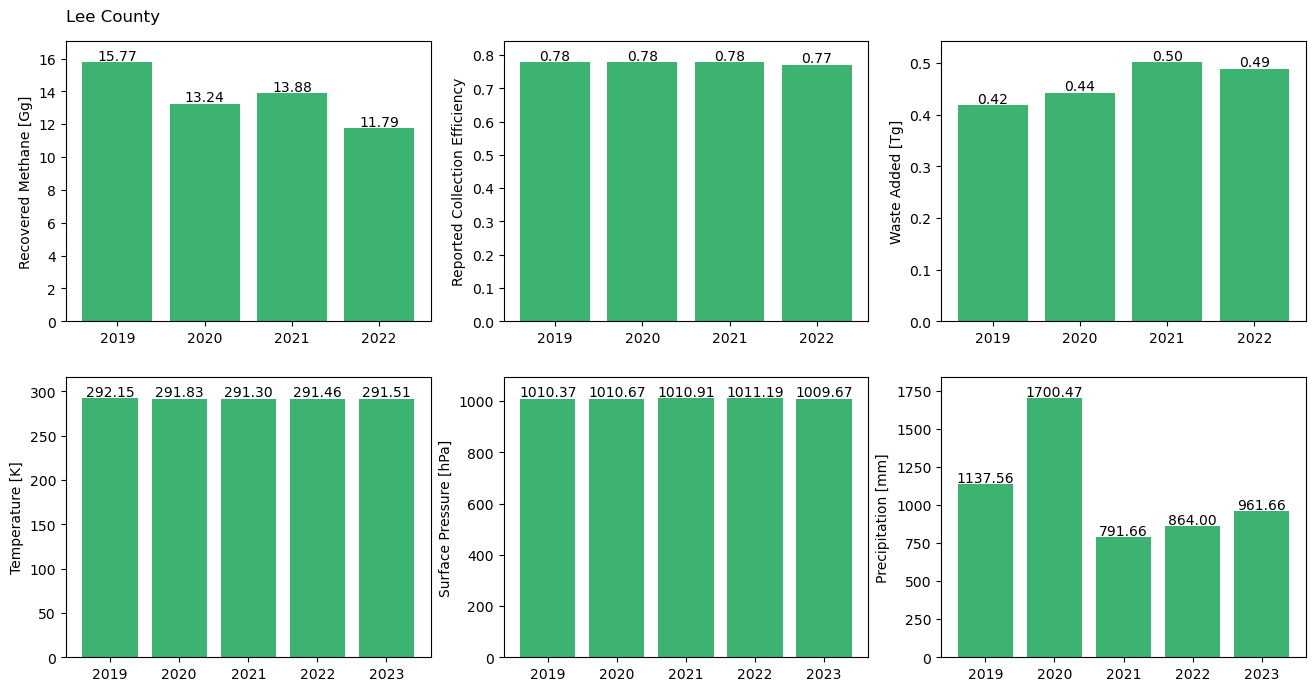

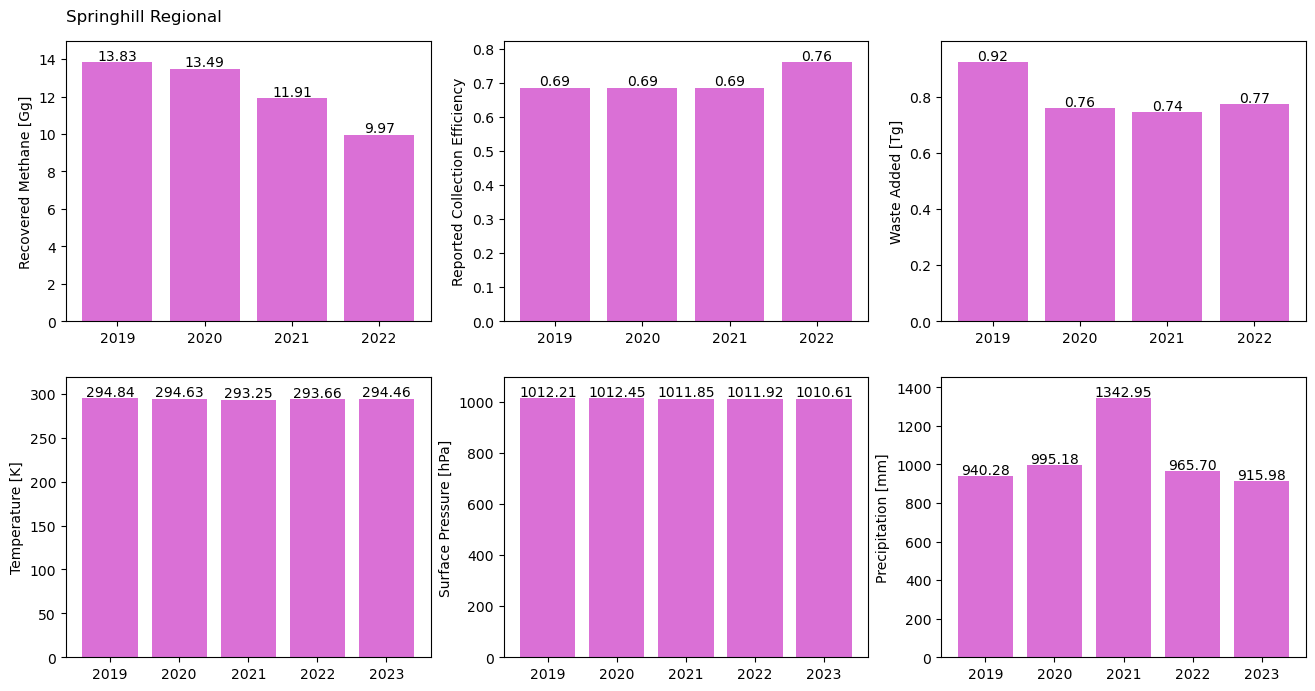

In [4]:
colors = ["salmon", "cornflowerblue", "mediumseagreen", "orchid"]
for idx,landfill in enumerate(["sampson", "charlotte", "lee", "springhill"]):
    fig,axs = plt.subplots(2, 3, figsize=(16,8))
    fig.suptitle(labels[landfill], x=0.125, y=0.92, ha="left")
    df = assembled[landfill]["data"]
    years = [2019, 2020, 2021, 2022, 2023]
    scales = [1e-3, 1, 1e-6, 1, 1e-2, 1]
    vars = ["Recovered", "Collection_Eff", "Waste_Added_This_Yr",
            "temperature", "surface_pressure", "precip"]
    ylabels = ["Recovered Methane [Gg]", "Reported Collection Efficiency",
              "Waste Added [Tg]", "Temperature [K]",
              "Surface Pressure [hPa]", "Precipitation [mm]"]
    for idy,ax in enumerate(axs.flatten()):
        ax.bar(years, df[vars[idy]]*scales[idy], color=colors[idx])
        for idz in df.index:
            if not np.isnan(df.loc[idz,vars[idy]]):
                ax.text(years[idz], df.loc[idz,vars[idy]]*scales[idy]*1.01, 
                        f"{df.loc[idz,vars[idy]]*scales[idy]:.2f}", ha="center")
        ax.set_ylabel(ylabels[idy])
        ylim = ax.get_ylim()
        ax.set_ylim([ylim[0], ylim[1]*1.03])

    fig.savefig(f"figures/figS{idx+1}.png", dpi=300, bbox_inches="tight", pad_inches=0.01)